In [ ]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_adres = "/content/drive/MyDrive/RGB.zip"
!cp "{zip_adres}" .

In [ ]:
!unzip -q /content/drive/MyDrive/RGB.zip
!rm RGB.zip

In [ ]:
DATASET = "/content/RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['desert', 'beach', 'residential', 'circularfarmland', 'mountain', 'forest', 'snowberg', 'rectangularfarmland', 'cloud', 'river']


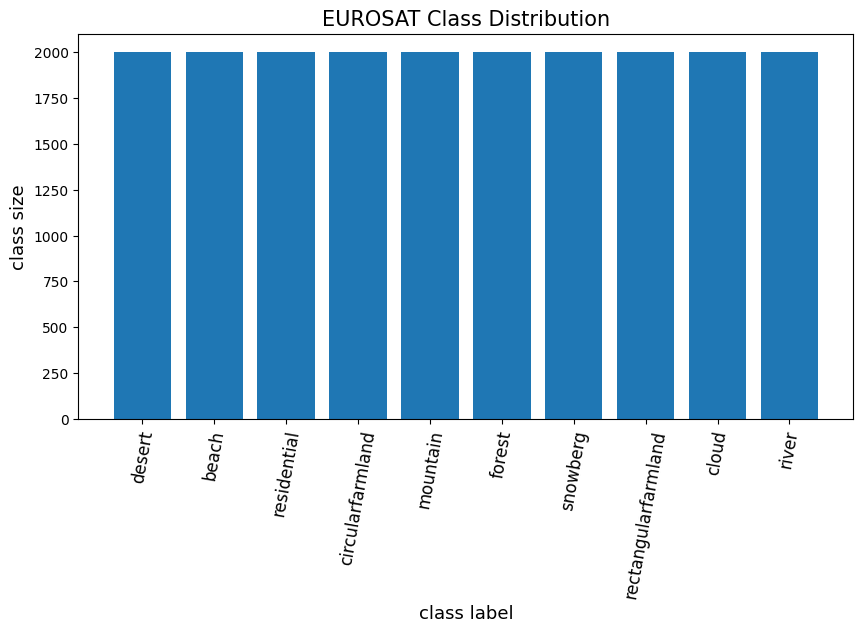

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(10, 5))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

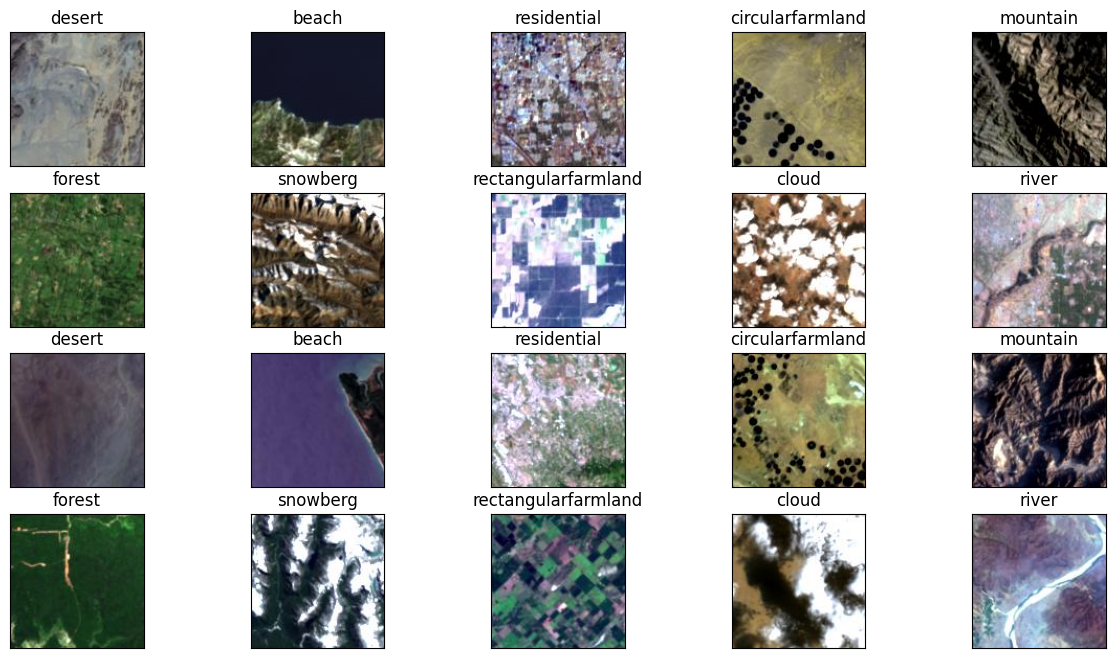

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/working/train'
TEST_DIR = '/content/working/test'
BATCH_SIZE = 128
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (128, 128, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:

    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/RGB', '/content/working/train', i) for i in train_paths]
    new_test_paths = [re.sub('/content/RGB', '/content/working/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 16000/16000 [00:01<00:00, 11167.49it/s]


moving testing files..


100%|██████████| 4000/4000 [00:00<00:00, 11093.89it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [ ]:
print(train_generator.class_indices)

{'beach': 0, 'circularfarmland': 1, 'cloud': 2, 'desert': 3, 'forest': 4, 'mountain': 5, 'rectangularfarmland': 6, 'residential': 7, 'river': 8, 'snowberg': 9}


In [ ]:
np.save('class_indices', train_generator.class_indices)

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.optimizers import Adagrad, Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from keras.applications import InceptionV3, Xception
from keras.applications import InceptionResNetV2

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
def compile_model(input_shape, n_classes, optimizer, fine_tune=None):

    conv_base = VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
                     #pooling='max')

    top_model = conv_base.output
    #top_model = GlobalMaxPooling2D(name='feature_layer')(top_model)
    top_model = Flatten()(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dropout(0.1)(top_model)
    top_model = Dense(1024, activation='relu')(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])

    return model

def plot_history(history):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show();

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)

    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds),
                            columns=class_labels,
                            index=class_labels)
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [ ]:
optim = Adam(lr=5e-4)

model = compile_model(INPUT_SHAPE, NUM_CLASSES, optim, fine_tune=None)
model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/content/working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.00001

scheduler = LearningRateScheduler(scheduler)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

<ipython-input-21-55d62992d129>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.0651 - categorical_accuracy: 0.7151
Epoch 1: val_categorical_accuracy improved from -inf to 0.90323, saving model to /content/working/model.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 78s 540ms/step - loss: 1.0651 - categorical_accuracy: 0.7151 - val_loss: 0.2895 - val_categorical_accuracy: 0.9032
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.3702 - categorical_accuracy: 0.8756
Epoch 2: val_categorical_accuracy improved from 0.90323 to 0.90751, saving model to /content/working/model.weights.best.hdf5
125/125 [==============================] - 69s 551ms/step - loss: 0.3702 - categorical_accuracy: 0.8756 - val_loss: 0.2765 - val_categorical_accuracy: 0.9075
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.3430 - categorical_accuracy: 0.8854
Epoch 3: val_categorical_accuracy improved from 0.90751 to 0.92490, saving model to /content/working/model.weights.best.hdf5
125/125 [==============================] - 70s 560ms/step - loss: 0.3430 - categorical_accuracy: 0.8854 - val_loss: 0.2204 - val_categorical_accuracy: 0.9249
Epoch 4/10
125/125 [==============================] - ETA: 0

In [ ]:
# re-train with fine-tuning
model_2 = compile_model(INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=5e-6), fine_tune=0)

model.load_weights('/content/working/model.weights.best.hdf5')

In [ ]:
train_generator.reset()
test_generator.reset()

In [ ]:
history2 = model_2.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=40,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

<ipython-input-24-008a8645cb90>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_2.fit_generator(train_generator,


Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 0.9820 - categorical_accuracy: 0.6747
Epoch 1: val_categorical_accuracy did not improve from 0.94153
125/125 [==============================] - 77s 538ms/step - loss: 0.9820 - categorical_accuracy: 0.6747 - val_loss: 0.2091 - val_categorical_accuracy: 0.9297
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 0.2115 - categorical_accuracy: 0.9276
Epoch 2: val_categorical_accuracy improved from 0.94153 to 0.95111, saving model to /content/working/model.weights.best.hdf5
125/125 [==============================] - 70s 557ms/step - loss: 0.2115 - categorical_accuracy: 0.9276 - val_loss: 0.1394 - val_categorical_accuracy: 0.9511
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 0.1418 - categorical_accuracy: 0.9539
Epoch 3: val_categorical_accuracy improved from 0.95111 to 0.96447, saving model to /content/working/model.weights.best.hdf5
125/125 [==============================] - 68s 

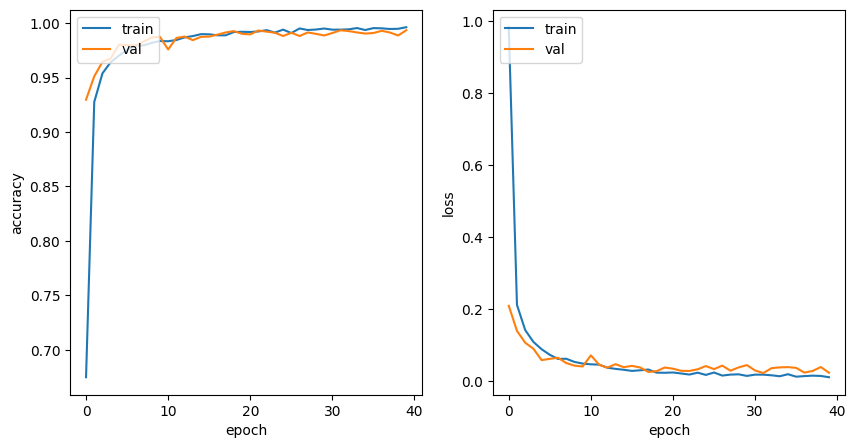

In [ ]:
plot_history(history2)

In [ ]:
#model_2.load_weights('/content/working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(128, 128),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = model_2.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 4000 images belonging to 10 classes.


<ipython-input-26-43e88425c516>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_2.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.99325
Global F2 Score: 0.99325


,Precision,Recall,F-Score,Support
beach,0.992462,0.9875,0.989975,400.0
circularfarmland,0.997500,0.9975,0.997500,400.0
cloud,0.997487,0.9925,0.994987,400.0
desert,0.992556,1.0000,0.996264,400.0
forest,0.997494,0.9950,0.996245,400.0
mountain,0.994987,0.9925,0.993742,400.0
rectangularfarmland,0.997462,0.9825,0.989924,400.0
residential,0.992537,0.9975,0.995012,400.0
river,0.970516,0.9875,0.978934,400.0
snowberg,1.000000,1.0000,1.000000,400.0


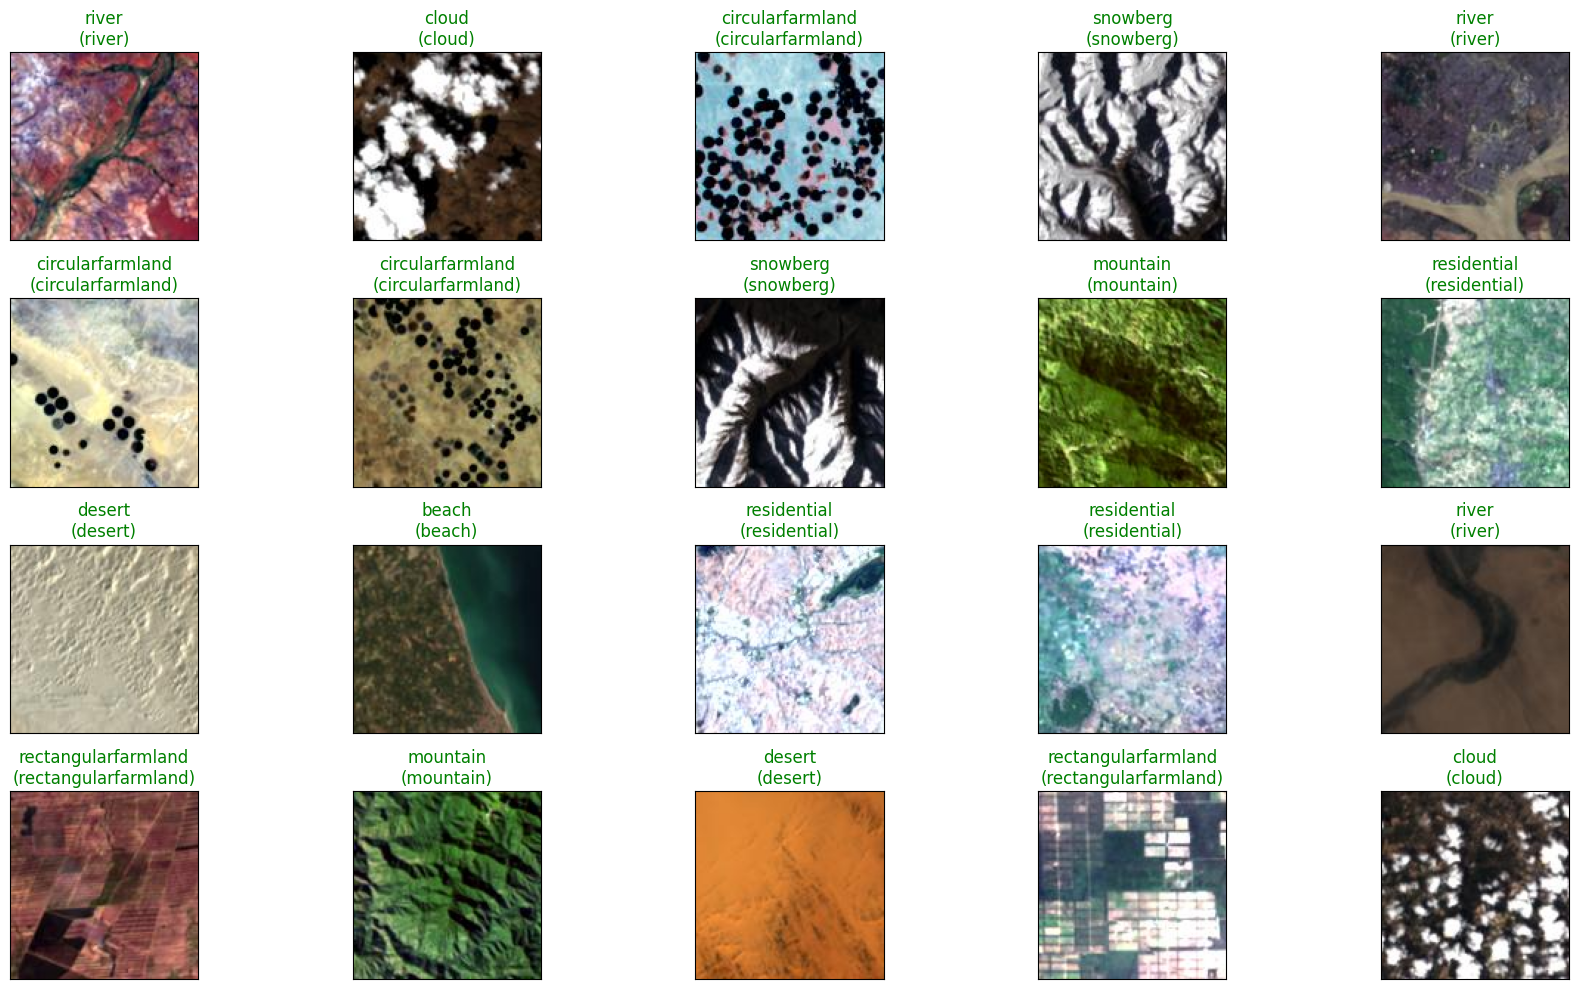

In [ ]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

1/1 [==============================] - 0s 20ms/step
3
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


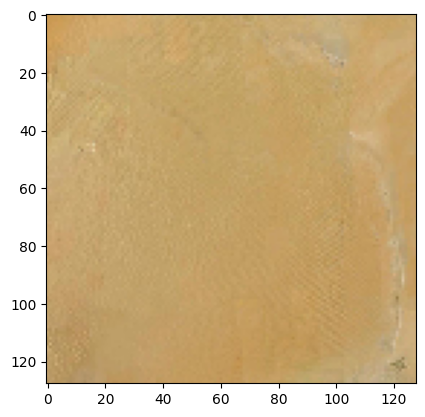

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# 1. Modelinizi Yükleyin
model_path = '/content/drive/MyDrive/model.weights.best.hdf5'
# Eğitildiği model mimarisiyle uyumlu bir VGG19 modeli oluşturun
 # Bu ağırlıklar eğitilmiş ImageNet veri kümesine aittir. İhtiyaca göre değiştirebilirsiniz.

# 2. Giriş Verisini Hazırlayın
img_path = '/content/Desert_21.jpg'
img = image.load_img(img_path, target_size=(128, 128))  # VGG19 için hedef boyutu (128, 128) olmalıdır.
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)  # VGG19 için özel ön işleme

# 3. Tahmin Yapın
predictions = model.predict(img_array)
my_Predict = np.argmax(predictions)

# 4. Sonuçları İnceleyin
print(my_Predict)
print(predictions)


plt.imshow(img)
plt.show()

In [ ]:
print(train_generator.class_indices)

{'beach': 0, 'circularfarmland': 1, 'cloud': 2, 'desert': 3, 'forest': 4, 'mountain': 5, 'rectangularfarmland': 6, 'residential': 7, 'river': 8, 'snowberg': 9}


In [ ]:
# Save the model and the weights

model_2.save('/content/working/VGG19_RGB_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
